# Detecting Fake News with logistic regression

## 📰 Introduction
In this assignment, you will analyze a dataset of news articles labeled as either 'real' or 'fake'.
You will explore the data, engineer features, build a logistic regression model package, and evaluate the model's performance.

Note: This assignment is based on Chapter 21 of the "Learning Data Science" textbook.
Link: https://learningds.org/ch/21/fake_news_intro.html

## 📦 Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer

## 📁 Step 2: Load and Understand the Data

Run the cell below to:
- Load the dataset from `fake_news.csv`.
- Display the first five rows to get an overview.

In [2]:
df = pd.read_csv('fake_news.csv')
df.head()

,timestamp,baseurl,content,label
0,2021-04-05 16:39:51.000000000,dailybuzzlive.com,Cannibals Arrested in Florida Claim Eating Hum...,fake
1,2016-01-01 23:17:43.000000000,houstonchronicle-tv.com,BREAKING: Trump fires Deputy Attorney General ...,fake
2,2016-03-06 15:50:39.000000000,higherperspectives.com,Keanu Reeves Shook The World With Another POWE...,fake
3,2017-11-13 14:53:49.000000000,eveningw.com,Breaking: Woman Says She Was Offered Big Money...,fake
4,2015-11-25 08:00:00.000000000,washingtonpost.com,"First family visits D.C. shelter, highlights h...",fake


The dataset comprises news articles labeled as either "REAL" or "FAKE". Each entry includes metadata and content of the article. More specifically, the following variables are included:
- `timestamp`: The date and time the article was published or collected.
- `baseurl`: The domain or website where the article was published.
- `content`: The full text of the news article.
- `label`: Indicates whether the article is real or fake. Values are "REAL" and "FAKE".

### Task 1: missing values
Check for data types and missing values.

In [3]:
# solution
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779 entries, 0 to 778
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  404 non-null    object
 1   baseurl    779 non-null    object
 2   content    779 non-null    object
 3   label      779 non-null    object
dtypes: object(4)
memory usage: 24.5+ KB
None
timestamp    375
baseurl        0
content        0
label          0
dtype: int64


*Interpretation*: We observe that the `timestamp` variable has lots of missing datapoints. This implies that we should not use this variable for predictions.

### Task 2: bias
(see Section 21.1 of "Learning Data Science")

This dataset is a simplified version of the FakeNewsNet data repository described in [Shu et al](https://arxiv.org/abs/1809.01286). This repository contains content from news and social media websites, as well as metadata like user engagement metrics. For simplicity, we only look at the dataset’s political news articles. This subset of the data includes only articles that were fact-checked by Politifact, a nonpartisan organization with a good reputation. Each article in the dataset has a “real” or “fake” label based on Politifact’s evaluation, which we use as the ground truth.

Politifact uses a nonrandom sampling method to select articles to fact-check. According to its website, Politifact’s journalists select the “most newsworthy and significant” claims each day. Politifact started in 2007 and the repository was published in 2020, so most of the articles were published between 2007 and 2020.

Summarizing this information, we determine that the target population consists of all political news stories published online in the time period from 2007 to 2020 (we would also want to list the sources of the stories). The access frame is determined by Politifact’s identification of the most newsworthy claims of the day.

Based on the dataset's structure and content, discuss potential sources of bias that could affect model performance. Consider aspects such as:
- The origin of the articles (e.g., specific publishers or websites).
- The time frame during which the articles were published.
- The topics covered and their distribution across real and fake news.
- Any preprocessing steps already applied to the dataset.

*Solution*:
- **Source Bias**: If the dataset predominantly features articles from specific publishers, the model might learn publisher-specific language patterns rather than generalizable features distinguishing real from fake news.
- **Temporal Bias**: Articles collected from a particular time frame might not represent the current language usage or topics, leading to a model that doesn't generalize well to newer articles.
- **Topic Bias**: If certain topics are overrepresented in either real or fake news categories, the model might associate topics with labels rather than detecting deceptive writing styles.
- **Preprocessing Bias**: If the dataset has undergone preprocessing (e.g., removal of stop words, lemmatization), it might affect the natural language structure, influencing the model's learning process.


## 📊 Step 3: Exploratory Data Analysis (EDA)

### Splitting the data in Training and Testing Sets

Before diving into EDA, we split our dataset into training (75%) and testing (25%) sets. For this sake, we use the method [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from the Scikit-learn package (click on the function name to access the documentation). Additionally, we ecode our `label` column by using `1` for the `fake` label and `0` for the `real` label.

In [4]:
from sklearn.model_selection import train_test_split

df['label'] = (df['label'] == 'fake').astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    df[['timestamp', 'baseurl', 'content']], df['label'],
    test_size=0.25, random_state=42,
)

In [5]:
df['label']

0      1
1      1
2      1
3      1
4      1
      ..
774    0
775    0
776    0
777    0
778    0
Name: label, Length: 779, dtype: int64

### Task 3: Exploring the distribution of real vs fake
- Count the number of real vs. fake articles in the training data. (Hint: Use [`value_counts()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html)))
- Compute the proportion of fake articles.
- Plot the class distribution. (Hint: Use [`sns.histplot()`](https://seaborn.pydata.org/generated/seaborn.histplot.html) or [`plt.hist()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html))

In [6]:
# solution 
y_train.value_counts()

0    320
1    264
Name: label, dtype: int64

In [7]:
fake_proportion = y_train.value_counts()[1]/y_train.size
fake_proportion

0.4520547945205479

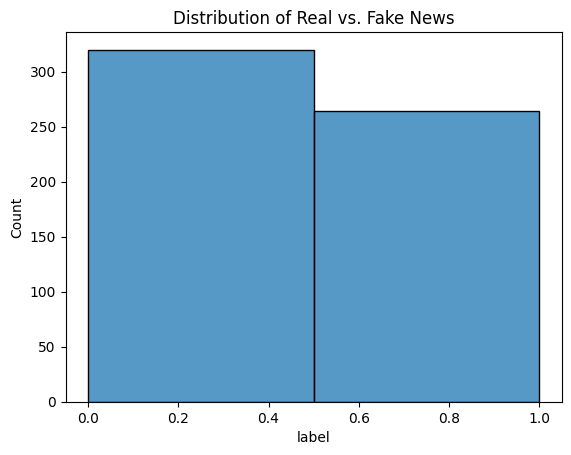

In [8]:
sns.histplot(y_train, bins=2)
plt.title('Distribution of Real vs. Fake News')
plt.show()

### Task 4: Exploring the publishers
Analyze the `baseurl` column to inspect article sources:
a) Count the number of articles per source. *(Hint: use `value_counts()`; [pandas docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html))*
b) Visualize the top 10 sources using a horizontal bar chart with the number of articles as value on the x-axis. (Hint: [`pd.Series.plot(kind='barh')`](https://pandas.pydata.org/docs/reference/api/pandas.Series.plot.html))
c) List the top 10 sources of fake news (`label == 1`).
d) List the top 10 sources of real news (`label == 0`).

In [9]:
#solution
source_counts = X_train['baseurl'].value_counts()
print("Top article sources:\n", source_counts.head(10))

Top article sources:
 whitehouse.gov        21
abcnews.go.com        20
nytimes.com           17
politifact.com        16
yournewswire.com      15
washingtonpost.com    14
foxnews.com           11
cnn.com               11
cq.com                11
msnbc.msn.com          9
Name: baseurl, dtype: int64


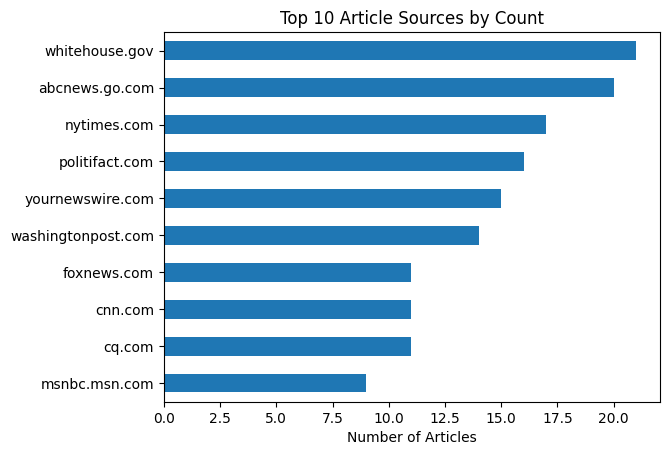

In [10]:
#solution b)
top_sources = source_counts.head(10)
top_sources.plot(kind='barh')
plt.xlabel('Number of Articles')
plt.title('Top 10 Article Sources by Count')
plt.gca().invert_yaxis()
plt.show()

In [11]:
#solution c)
top_fake_sources = X_train[y_train == 1]['baseurl'].value_counts().head(10)
print("Top 10 Fake News Sources:\n", top_fake_sources)

Top 10 Fake News Sources:
 yournewswire.com            15
thegatewaypundit.com         5
thehill.com                  4
dailyusaupdate.com           4
worldnewsdailyreport.com     3
observeronline.news          3
trendolizer.com              3
washingtonpost.com           3
newsweek.com                 3
freedomcrossroads.us         3
Name: baseurl, dtype: int64


In [12]:
#solution d)
top_real_sources = X_train[y_train==0]['baseurl'].value_counts().head(10)
print("Top 10 Real News Sources:\n", top_real_sources)

Top 10 Real News Sources:
 whitehouse.gov        21
abcnews.go.com        20
nytimes.com           16
politifact.com        15
cq.com                11
washingtonpost.com    11
foxnews.com           10
msnbc.msn.com          9
cnn.com                8
medium.com             5
Name: baseurl, dtype: int64


Observe that there are many different source urls and only very few base urls with a high number of articles. Additionally, `washingtonpost.com` is included in both, the top 10 face news sources as well as the top 10 real news sources. We conclude that the variable `baseurl` might not be the best predictor.

In [13]:
X = pd.DataFrame({
    'col1' : [1,2,3,4],
    'col2': [3,4,5,6]
})

### Task 5: Exploring words
In this task, we want to explore whether there’s a connection between the language used in the articles and whether they were identified as fake. A straightforward approach is to focus on specific words—like military—and count how often articles containing that word were labeled as fake. For a word like military to be considered informative, the percentage of fake articles that mention it should be significantly higher or lower than 45%, which is the overall proportion of fake articles in the dataset (264 out of 584).

Define a function `make_word_features()` with the following signature:
- arguments:
    - DataFrame `df` which needs to have a column called `content`
    - list `words`
- output: DataFrame with the same number of observations as `df` and with one column per word in the input list `word`. For each sample word the new feature contains either `True` or `False` depending on whether the word is contained in `content` or not.


*Hints:* 
- You can create a DataFrame from a dictionary (see [here](https://www.geeksforgeeks.org/how-to-create-dataframe-from-dictionary-in-python-pandas/))
- To check whether a certain word in included in a string, use the function [`str.contains()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html) (click to open the documentation).

In [ ]:
# solution
def make_word_features(df,words):
    new_features = pd.DataFrame({word: df['content'].str.contains(word) for word in words})
    return new_features
    

Next, we test your new function with some words.

### Task 6: Interpreting word predictors
In the cell below, we test your new function with some test words. The subsequent cell creates a graph to visualize the results. Carefully look at the test words and at the result of this analysis. What conclusions can we draw from this regarding our modeling task?

In [ ]:
# run this cell
word_features = [
    'trump', 'clinton', # names of presidents
    'state', 'vote', 'congress', 'shutdown', # congress words
    'military', 'princ', 'investig', 'antifa', 'joke', 'homeless',
    'swamp', 'cnn', 'the' #other possibly useful words
]
df_words = make_word_features(df, word_features)
df_words

In [ ]:
# run this cell
fake_props = (make_word_features(X_train, word_features)
 .assign(label=(y_train == 1))
 .melt(id_vars=['label'], var_name='word', value_name='appeared')
 .query('appeared == True')
 .groupby('word')
 ['label']
 .agg(['mean', 'count'])
 .rename(columns={'mean': 'prop_fake'})
 .sort_values('prop_fake', ascending=False)
 .reset_index()
 .melt(id_vars='word')
)

g = sns.catplot(
    data=fake_props,
    x='value',
    y='word',
    col='variable',
    hue='variable',        # Color-code by the type of metric (prop_fake or count)
    s=15,                  # Increase dot size
    jitter=False,
    sharex=False,
    height=3,
    aspect=1.3
)


[[prop_ax, _]] = g.axes
prop_ax.axvline(fake_proportion, linestyle='--')
prop_ax.set(xlim=(-0.05, 1.05))

titles = ['Proportion of articles marked fake', 'Number of articles with word']

for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
    ax.set(title=title)
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    ax.yaxis.grid(True);

*Observations*:
- Words which are close to the dotted line at 0.45 (the proportion of fake articles) are unlikely to be good predictors for fake news.
- For example, *antifa* is highly predictive for fake news. On the other hand, *antifa* appears only in a small number of articles which makes it less worthy for predicting fake news.
- The article *the* appears in nearly every article, but it is useless for prediction because it appears in as many real news as fake news.
- The term *vote* is a candidate predictor because it appears in many articles and at the same time it has a high predictive power.

## 🧠 Step 4: Modeling

### Task 7: Building our first logistic regression model
Our EDA showed that the word *vote* is related to whether an article is labeled real or fake. To test this, we fit a logistic regression model using a single binary feature: `1` if the word vote appears in the article and `0` if not.

To do so, follow the steps below (see slide 7 of the small slide deck for today's lecture):

a) Write a function `lowercase` that takes a dataframe `df` as argument and returns a copy of this dataframe with the `content` column of the `df` dataframe being transformed to lowercase strings. (Hint: apply the [.str.lower()](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.lower.html) method)

b) Create a pipeline using [make_pipeline()](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) which includes the following elements:
- Preprocessing step 1: your `lowercase` function from step 1 (wrapped into the pipeline using [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html))
- Preprocessing step 2: your `make_word_features` function from Taks 5, using *vote* as the only word to check for.
- Modeling step: `LogisticRegression(penalty='none')

c) Train the model on the training data (`fit()`)

d) Evaluate the accuracy score

In [ ]:
# Solution a)
def lowercase(df):
    df_new = df.copy()
    df_new['content'] = df_new['content'].str.lower()
    return df_new

In [ ]:
# solution b)
one_word = ['vote']
model1 = make_pipeline(
    FunctionTransformer(lowercase),
    FunctionTransformer(make_word_features, kw_args={'words' : one_word}),
    LogisticRegression(penalty=None)
)

In [ ]:
# solution c) 
model1.fit(X_train,y_train)

In [ ]:
print(f'{model1.score(X_train, y_train):.1%} accuracy on training set.')

In [ ]:
# solution d)
y_pred = model1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) 
print(f"Accuracy: {accuracy:.2f}")

Run the cell below to see the accuary matrix:

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    model1, X_test, y_test, cmap=plt.cm.Blues, colorbar=False
)
plt.grid(False);

### Task 8: Interpreting our first logistic regression model
Extract the coefficients of your logistic regression model from Task 7. With these, compute the probability for your model gives to an article that contains the word *vote* to be fake. Do the same for an article that does not contain the word *vote*.

(Hint: You can access the logistic regression model from the pipeline by accessing `model1.steps[2][1]` (because the logistic regression is the third step in the pipeline which has the Python index 2, the model is then the second entry of a tuple which has index 1). From this you get the coefficients as `coef_` respectively as `incercept_`. E.g., the *vote* coefficient is computed as `model1.steps[2][1].coef_`)

In [ ]:
intercept = model1.steps[2][1].intercept_[0]
vote_coef = model1.steps[2][1].coef_[0,0] #['logisticregression'].coef_

In [ ]:
intercept

In [ ]:
vote_coef

In [ ]:
import math
p_vote_present = math.exp(intercept + vote_coef)/(1 + math.exp(intercept+vote_coef))
p_vote_present

In [ ]:
import math
p_vote_absent = math.exp(intercept)/(1 + math.exp(intercept))
p_vote_absent

### Task 9: Building a more complex model
Now create a model that uses all of the words we examined in our EDA of the train set, except for *the*. Again compute the accuracy and display the confusion matrix.

In [ ]:
#solution
word_features = [
    'trump', 'clinton', # names of presidents
    'state', 'vote', 'congress', 'shutdown', # congress words
    'military', 'princ', 'investig', 'antifa', 'joke', 'homeless',
    'swamp', 'cnn', 'the' #other possibly useful words
]
model2 = make_pipeline(
    FunctionTransformer(lowercase),
    FunctionTransformer(make_word_features, kw_args={'words' : word_features}),
    LogisticRegression(penalty=None)
)
model2.fit(X_train,y_train)
print(f'{model2.score(X_train, y_train):.1%} accuracy on training set.')

In [ ]:
#accuracy
y_pred = model2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) 
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    model2, X_test, y_test, cmap=plt.cm.Blues, colorbar=False
)
plt.grid(False);